# Importando os dados

In [1]:
import requests,json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as pd
import numpy as np
import pymysql.cursors

C:\Users\andre\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  after removing the cwd from sys.path.


### Transformada do Cosseno

In [2]:
import math, time
def dct(p):
    n = len(p)
    mat = []
    suma = 0
    cte=math.sqrt(2/n)
    cf = 0
    for i in range(n):
        if i==0: cf = 1/math.sqrt(2)
        else: cf = 1
        for t in range(n):
            theta = ((2*t+1)*i*math.pi)/(2*n)
            suma = suma + p[t]*math.cos(theta)
        suma = cf*suma*cte
        mat.append(np.round(suma, decimals=3))
        suma = 0
    return mat

def idct(g):
    n = len(g)
    cte = math.sqrt(2/n)
    imat = []
    suma = 0
    cj = 0
    for i in range(n):
        suma = 0
        for t in range(n):
            if t==0: cj=1/math.sqrt(2)
            else: cj=1
            theta = ((2*i+1)*t*math.pi)/(2*n)
            suma = suma + cj*g[t]*math.cos(theta)
        suma = suma*cte
        imat.append(np.round(suma, decimals=3))
    return imat

## Lidando com os dados

In [3]:
#Função para importar os dados
def import_data_tec(ano_i: int,ano_f: int, lat: float):
    try:
        banco=pymysql.connect(
            host='localhost',
            user='root',
            password='',
            db='tecdata',
            charset='utf8mb4',
            cursorclass=pymysql.cursors.DictCursor
        )
    except:
        print('error ao conectar com o banco de dados')
    
    dic = []
    dias = 365
    
    for ano in range(ano_i,ano_f+1):
        tb_name = str(ano)+'_'+str(float(lat))
        with banco.cursor() as cursor:
            cursor.execute('SELECT * FROM `'+tb_name+'` ORDER BY id ASC LIMIT 0,4745')
            dados = cursor.fetchall()
            dic = dic + dados 
            
    return dic

def import_data(ano_i: int, ano_f: int):
    try:
        banco=pymysql.connect(
            host='localhost',
            user='root',
            password='',
            db='tecdata',
            charset='utf8mb4',
            cursorclass=pymysql.cursors.DictCursor
        )
    except:
        print('error ao conectar com o banco de dados')
        
    PF = []
    for ano in range(ano_i,ano_f+1):
        tb_name = "photonflux_"+str(ano)
        with banco.cursor() as cursor:
            cursor.execute('SELECT * FROM `'+tb_name+'` ORDER BY id ASC LIMIT 0,4745')
            dados = cursor.fetchall()
            PF = PF + dados
    return PF

# Função para filtrar os dados
def filtra_dados(ano_i: int, ano_f: int, banda: str, lon:int, dic: list, PF: list):
    dados = []
    dias = 365
    step = 0
    factor = ano_f-ano_i + 1
    
    #Selecionando os dados para uma dada longitude
    for i in range(13*dias*factor):
            dados.append(dic[i][str(lon)])#Longitude

    #Criando e colocando o fluxo de fótons em uma lista
    photon_flux = []
    for i in range(dias*factor):
        photon_flux.append(float(PF[i][banda]))
    
    #Aqui normalizamos os dados de PF
    y = []
    for i in range(len(photon_flux)):
        y.append((photon_flux[i] - np.mean(photon_flux))/(max(photon_flux)-min(photon_flux)))
    
    return dados, y

# Função para salvar os dados em um dataFrame
def salva_dataframe(ano_i:int, ano_f:int, dados: list, PF:list):
    index = ['coef '+str(i) for i in range(1,14,1)] + ['Photon flux'] 
    TEC_f = pd.DataFrame(index=index) #Tec na frequência
    step = 0
    dias = 365
    factor = ano_f-ano_i + 1
    for dias in range(1,factor*dias+1):
        data = dados[step:step+13] + [PF[dias-1]]
        data = np.array(data).reshape(14,1)
        TEC_f[dias] = data
        step = step+13


    #Vamos aplicar aqui a DCT ao DataFrame TEC_f
    for i in range(1,dias+1):
        TEC_f[i][0:13] = dct(list(TEC_f[i][0:13]))  

    TEC_f = TEC_f.transpose()
    return TEC_f

def correlacao(TEC_f):
    corr_1 = [] #F10.7
    for i in range(1,14):
        filt = pd.DataFrame(TEC_f['coef '+str(i)])
        filt['Photon flux'] = TEC_f['Photon flux']
        a = filt.corr()
        a = abs(a)
        corr_1 = corr_1 + [a['coef '+str(i)][1]]
    return corr_1

In [4]:
lat = []
step = 50
while step != -52.5:
    lat.append(step)
    step -= 2.5
    
longitude = -50
ano_i = 2016
ano_f = 2019

PF = import_data(ano_i,ano_f)

bandas = ["1.86-2.95","3.00-4.92","5.05-10.00","10.05-14.84","15.01-19.86", "20.00-24.92", "25.63-25.63", "28.41-28.41", "25.11-29.95", "30.33-30.33", "30.38-30.38", "30.33-34.99", "36.81-36.81", "35.60-39.98", "40.11-43.67", "46.52-46.52", "45.30-49.94", "50.00-55.00", "58.43-58.43", "55.44-59.96", "60.98-60.98", "62.97-62.97", "60.98-64.41", "65.03-70.00", "70.34-70.34", "70.10-75.00", "76.52-76.52", "77.04-77.04", "78.77-78.77", "75.00-80.00", "80.10-85.00", "85.10-90.00", "90.10-95.00", "97.70-97.70", "95.10-100.00", "102.57-102.57", "103.19-103.19", "100.10-105.00"]

In [7]:
corr_PF = []
corr_bandas = []
tec_lat = []
for lat in lat:
    dic = import_data_tec(ano_i,ano_f, lat_i)
    tec_lat.append(dic)

In [ ]:
for banda in bandas:
    for i in range(len(lat)):
        #Filtrando os dados para determinada latitude
        dados, photon_flux = filtra_dados(ano_i,ano_f, banda, longitude, tec_lat[i], PF)

        #Salvando em um dataframe os dados filtrados
        TEC_f = salva_dataframe(ano_i,ano_f, dados, photon_flux)

        #Calculo da correlação
        corr_PF.append(correlacao(TEC_f))
    corr_bandas.append(corr_PF)
    corr_PF = []

## Realizando a análise

In [ ]:
multi_bandas = []
for banda in bandas:
    for rep in range(13):
        multi_bandas.append(banda)
    
index = ['coef '+str(i) for j in range(len(bandas)) for i in range(1,14)]
hier_index = list(zip(multi_bandas,index))
hier_index = pd.MultiIndex.from_tuples(hier_index)

lat_str = str(lat).split(',')
lat_str[0] = lat_str[0][1::]
lat_str[len(lat)-1] = lat_str[len(lat)-1][::-1]
lat_str[len(lat)-1] = lat_str[len(lat)-1][1::]
lat_str[len(lat)-1] = lat_str[len(lat)-1][::-1]

#Em cada índice de corr_bandas corresponde a uma banda, mesma matriz que tinhamos
#Em cada subíndice tenho os coef de uma lat para uma banda
matriz = []
for i in range(len(bandas)):
    a = list(np.array(corr_bandas[i][j]).reshape(13,1) for j in range(len(lat)))
    mat = np.concatenate(a[0::], axis=1)
    matriz.append(mat) 

matriz = np.concatenate(matriz[0::])
correlacao = pd.DataFrame(matriz, index=hier_index,columns=lat_str)

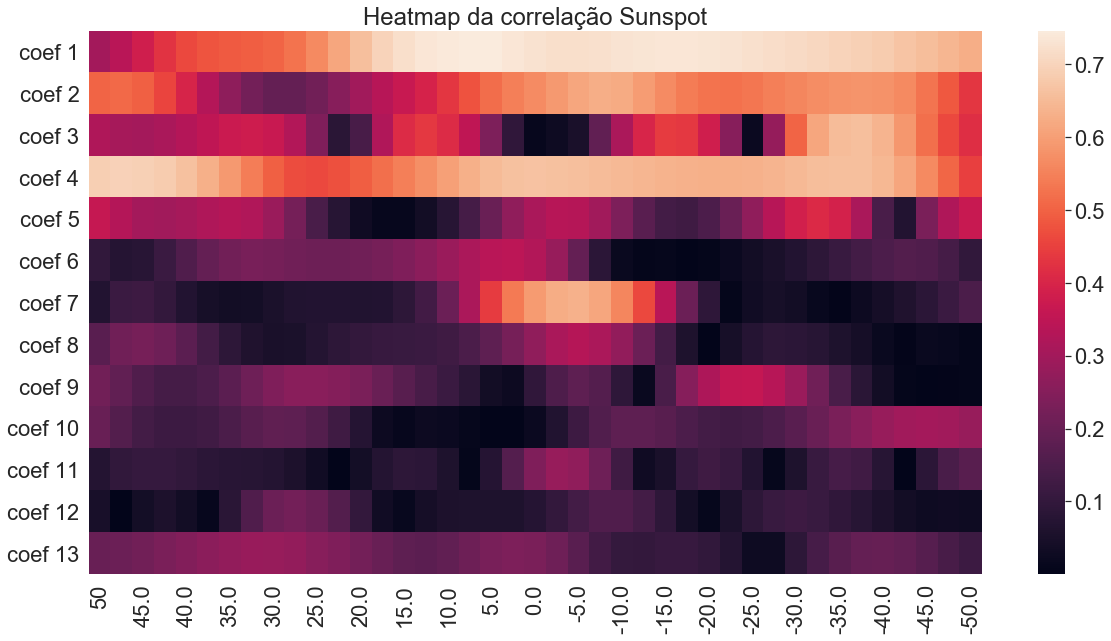

In [45]:
images_dir = 'resultados_latitudevariante'

index = ['coef '+str(i) for i in range(1,14)]
correlacao = pd.DataFrame(index=index)

for i in range(len(lat)):
    correlacao[str(lat[i])] = np.array(corr_PF[i]).reshape(13,1)
correlacao

fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel('Latitudes')
ax.set_ylabel('Coeficientes da DCT')
sns.set(font_scale=2)
graph = sns.heatmap(abs(correlacao), ax=ax)
ax.set_title('Heatmap da correlação do fluxo de fótons', fontdict={'fontsize':24})
fig.savefig(f"{images_dir}/Photon_flux.png")